In [ ]:
!pip install JSAnimation
!sudo apt-get install texlive-latex-recommended
!sudo apt install texlive-latex-extra
!sudo apt install dvipng
!sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended cm-super

Three propellers generate torques and forces in the body frame to translate and rotate the multirotor system. We can obtain the *local* wrench $\mathbf{w} = [\mathbf{f}^\top, \boldsymbol\tau^\top]^\top$ by using the mapping $\mathbf{A}$ from the input vector $\mathbf{u}$: $\mathbf{w=Au}$. Then accounting the effects of gravity, the rotation of the drone in the reference frame, and the inertia, we can obatin the derivative of the states by applying 
\begin{equation}
\dot{\mathbf{X}} = \begin{bmatrix}
        \frac{1}{m}\mathbf{R}^\top & \mathbf{O}\\
        \mathbf{O} & \mathbf{I}^{-1}_S
    \end{bmatrix}(\mathbf{A}\mathbf{u}
    - 
    \begin{bmatrix}
        nmg\mathbf{\hat e}_3\\
        \mathbf{I}_S\boldsymbol\omega\times\boldsymbol\omega
    \end{bmatrix}).
\end{equation}

We can find the way to calculate the `A` matrix in the code...

In [3]:
import numpy as np

# initial states: [x0, y0, theta0, dx0, dy0, dtheta0]
x0 = [0, 0, 0, 0, 0, 0]
# inertia
I = 0.01
# mass
m = 0.05

# Do we want constains?
en_constrain = True
# simulation time
time_out = 100

# number of motors
n = 2
# position of the thrusters
d = 0.2
p = np.array([[-0.1, -d], [0.1, -d]]).T
# tilting angles of the propellers
alpha = np.array([-45, 45])*np.pi/180.0
# A-matrix of the quadrotor
Af = np.zeros([2, n]);
Atau = np.zeros([1, n]);
R = np.zeros([2, 2*n]);
for i in range(n):
    R[:, 2*i:2*i+2] = [[np.cos(alpha[i]), -np.sin(alpha[i])],
                       [np.sin(alpha[i]), np.cos(alpha[i])]]
    Af[:,i] = R[:, 2*i:2*i+2].dot(np.array([0, 1]))
    Atau[:,i] = np.cross(p[:,i], Af[:,i])

A = np.concatenate([Af, Atau], axis=0)
# assert np.linalg.matrix_rank(A) == 3
# gravity acceleration
g = 9.8
# time step
dt = 0.001
# max force of a propeller
fM = 1
# minimum force of a propeller
fm = 0
# desired state
des_state = np.array([3, 2, 0.0, 0.0, 0.0, 0.0])
length = int(time_out//dt)
des_state_log = np.zeros((length, 6))

In [4]:
Fb = 0.3 # Bouyant Force Default = 0.3
L = 0.04 # Distnace from center of mass to center of lift Default = 0.2
rate = 0.04
damping_w = 0.0
damping_pos = 0.0

# step function for the motion of the drone
def step(state, f):
    x, y, theta, dx, dy, dtheta = state
    # calculate wrench
    w = np.array([[np.cos(theta), -np.sin(theta), 0], 
                 [np.sin(theta), np.cos(theta), 0], 
                  [0, 0, 1]]).dot(A.dot(f))
    
    fx, fy, tau = w
    dstate = np.array([dx, dy, dtheta, (fx - damping_pos*dx)/m, (fy+Fb - damping_pos*dy)/m-g, (tau - Fb*L*np.sin(theta) - damping_w*dtheta)/I])
    new_state = state + dstate*dt

    # make sure the range of theta is in (-pi, pi]
    if new_state[2] <= -np.pi:
        new_state[2] += 2*np.pi
    elif new_state[2] > np.pi:
        new_state[2] -= 2*np.pi
    return new_state

Once we have the curernt states $\mathbf{X}, \dot{\mathbf{X}}$ and the desired state $\mathbf{X}^{des}, \dot{\mathbf{X}}^{des}$, based on linear feedback, we can calculate the desired wrench by using a PID.

<!-- I made a mistake when designing the system. We have 3 DoF and 3 actuators. Thus, this is a non-redundent fully-actuated system. Therefore, by using $\mathbf{u} = \mathbf{A}^{-1}\mathbf{w}^{des}$, we are obtaining the only answer. Therefore, the convex optimization does not give any extra benefit here. -->

In [5]:
from numpy.random import default_rng
rng = default_rng()

Kpx = 0.15
Kdx = 0.18
Kpz = 2.2
Kdz = 1.8
Ktheta = -.1
Komega = -.1
isFullyActuated = np.linalg.matrix_rank(A) == 3
Axy = A[0:2, :]
def control(state, des_state, en_constrain):
    theta = state[2]
    
    # des_state[0] *= (1 + 0.1*rng.uniform())
    # des_state[1] *= (1 + 0.1*rng.uniform())
    err = des_state - state
    if err[2] <= -np.pi:
        err[2] += 2*np.pi
    elif err[2] > np.pi:
        err[2] -= 2*np.pi

    # linear feedback
    des_w = np.array([Kpx*err[0]+Kdx*err[3], 
                      Kpz*err[1]+Kdz*err[4]+m*g-Fb, 
                      Ktheta*err[2]+Komega*err[5]])



    R = np.array([[np.cos(theta), -np.sin(theta), 0],
                  [np.sin(theta), np.cos(theta), 0], 
                  [0, 0, 1]])
    
    # R_compensation = np.array([[np.cos(des_w[2]), -np.sin(des_w[2]), 0],
    #                            [np.sin(des_w[2]), np.cos(des_w[2]), 0], 
    #                            [0, 0, 1]])
    # R_compensation = np.eye(3)
    
    # B = R.dot(A)
    # if False:
    #     # cvx to constrain the forces
    #     # Construct the problem.
    #     u = cp.Variable(n)
    #     objective = cp.Minimize(cp.norm_inf(u))
    #     constraints = [B*u == des_w, fm <= u, fM >= u]
    #     prob = cp.Problem(objective, constraints)
    #     # The optimal objective value is returned by `prob.solve()`.
    #     result = prob.solve()
    #     if prob.status == cp.OPTIMAL:
    #         f = u.value
    #     else:
    #         # Maybe we have no valid solution
    #         print("Not achievable: ", des_w)
    #         f = np.linalg.pinv(A).dot(des_w)
    # else:
    if isFullyActuated:
        f = np.linalg.pinv(A).dot(R.T.dot(des_w))
    else:
        # f = np.linalg.pinv(Axy).dot(R[0:2,0:2].T.dot(R_compensation[0:2,0:2].T.dot(des_w[:2])))
        f = np.linalg.pinv(Axy).dot(R[0:2,0:2].T.dot(des_w[:2]) + np.array([-des_w[2], des_w[2]]))
    if en_constrain: 
        return clamp(f, fm, fM)
    else:
        return f

def clamp(vec, minimum, maximum):
    for i in range(len(vec)):
        if vec[i] < minimum:
            vec[i] = minimum
        elif vec[i] > maximum:
            vec[i] = maximum
    return vec

In [6]:
def simulate(init_state, time_out=20):
    global des_state
    global des_state_log
    global rate
    length = int(time_out//dt)
    state_log = np.zeros((length, 6))
    error_log = np.zeros((length, 6))
    # desstate_log = np.zeros((length, 6))
    f_log = np.zeros((length, n))
    state = init_state
    count = 0
    center_x = 0
    center_y = 0
    radius = 5
    period = 2*np.pi*radius/rate

    while count < length:
        alpha = rate*count*dt/radius
        des_state = np.array([radius*np.cos(alpha) + center_x, radius*np.sin(alpha) + center_y, 0, 0, 0, 0])
        # if count % (length//100) == 0:
        #     print("{} percent".format(count//(length//100)))
        state_log[count, :] = state
        des_state_log[count, :] = des_state
        error = des_state - state
        error_log[count, : ] = error
        # desstate_log[count, :] = des_state
        f = control(state, des_state, en_constrain)
        f_log[count, :] = f
        state = step(state, f)
        count += 1
    print("Finished\n")
    return state_log, f_log, error_log

In [ ]:
state_log, f_log = simulate(x0, time_out)
print(len(state_log))

Ld Testing

0.2
Finished

0.21000000000000002
Finished

0.22000000000000003
Finished

0.23000000000000004
Finished

0.24000000000000005
Finished

0.25000000000000006
Finished

0.26000000000000006
Finished

0.2700000000000001
Finished

0.2800000000000001
Finished

0.2900000000000001
Finished

0.3000000000000001
Finished

0.3100000000000001
Finished

0.3200000000000001
Finished

0.3300000000000001
Finished

0.34000000000000014
Finished

0.35000000000000014
Finished

0.36000000000000015
Finished

0.37000000000000016
Finished

0.38000000000000017
Finished

0.3900000000000002
Finished

0.4000000000000002
Finished

0.4100000000000002
Finished

0.4200000000000002
Finished

0.4300000000000002
Finished

0.4400000000000002
Finished

0.45000000000000023
Finished

0.46000000000000024
Finished

0.47000000000000025
Finished

0.48000000000000026
Finished

0.49000000000000027
Finished

0.5000000000000002
Finished

0.5100000000000002
Finished

0.5200000000000002
Finished

0.5300000000000002
Finished

0.54000000000

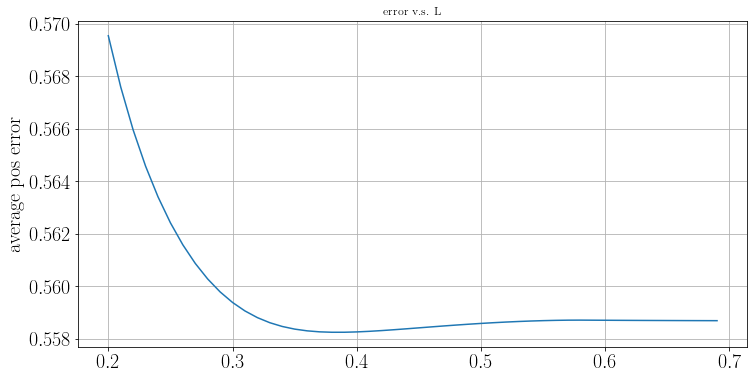

In [8]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import os
import sys
import time
import pickle
plt.rc('font', family='serif')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('figure', figsize=(12,6))
plt.rc('legend', fontsize=10)
plt.rc('axes', titlesize=20)
plt.rc("axes", labelsize=20)
rate = 0.5
L = 0.19
output_log = np.zeros((50,2)) #[L, avg error]
for i in range(50):
  L += 0.01
  print(L)
  state_log, f_log, error_log = simulate(x0, time_out)
  mag_pos_err = np.linalg.norm(np.array([error_log[:,0], error_log[:,1]]),axis=0)
  avg_pos_err = np.mean(mag_pos_err)
  output_log[i] = np.array([L, avg_pos_err])

max_theta = np.max(np.abs(error_log[:, 2]))
avg_theta = np.mean(error_log[:, 2])
min_error = np.min(output_log[:, 1])
best_L = output_log[output_log[:, 1].tolist().index(min_error)][0]

directory = ("drive/MyDrive/Simulations/L-Test-"+time.asctime(time.localtime())).replace(":", "-")
os.mkdir(directory)

with open("./"+directory+"/output_log.dat", "wb") as file:
    pickle.dump(output_log, file)

with open(directory+"/data.txt", "a") as f:
  f.write(
        "Minimum Average Error: %f\n" \
        "Best L: %f\n" \
        "Max Theta: %f\n" \
        "Average Theta: %fm\n"% (
        min_error, best_L, max_theta, avg_theta
              ))
  

fig1 = plt.figure()
ax11 = fig1.add_subplot(111)
ax11.grid()
ax11.set_ylabel('average pos error')
plt.xlabel("$XL_{b}$")
plt.title('error v.s. L_{b}')
plt.plot(output_log[:,0], output_log[:, 1])
plt.savefig(directory+"/Error-vs-L.pdf")
  


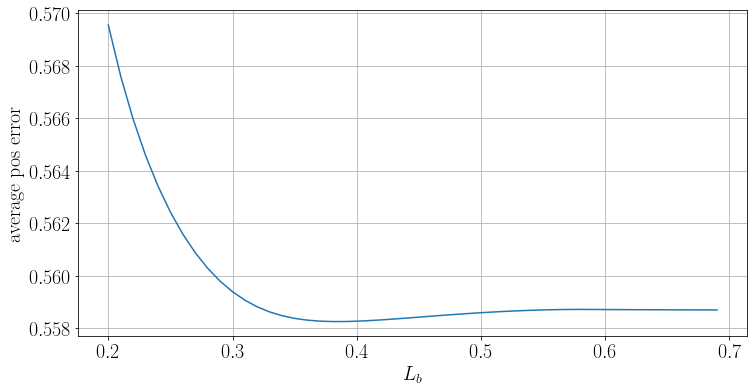

In [17]:
plt.rc('font', family='serif')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('figure', figsize=(12,6))
plt.rc('legend', fontsize=10)
plt.rc('axes', titlesize="larger")
plt.rc("axes", labelsize=20)
fig1 = plt.figure()
ax11 = fig1.add_subplot(111)
ax11.grid()
ax11.set_ylabel('average pos error')
plt.xlabel("$L_{b}$")
#ax11.set_title('error v.s. $L_{b}$')
plt.plot(output_log[:,0], output_log[:, 1])
plt.savefig(directory+"/Error-vs-L.pdf")

Rate Testing

0.05
Finished

0.060000000000000005
Finished

0.07
Finished

0.08
Finished

0.09
Finished

0.09999999999999999
Finished

0.10999999999999999
Finished

0.11999999999999998
Finished

0.12999999999999998
Finished

0.13999999999999999
Finished

0.15
Finished

0.16
Finished

0.17
Finished

0.18000000000000002
Finished

0.19000000000000003
Finished

0.20000000000000004
Finished

0.21000000000000005
Finished

0.22000000000000006
Finished

0.23000000000000007
Finished

0.24000000000000007
Finished

0.25000000000000006
Finished

0.26000000000000006
Finished

0.2700000000000001
Finished

0.2800000000000001
Finished

0.2900000000000001
Finished

0.3000000000000001
Finished

0.3100000000000001
Finished

0.3200000000000001
Finished

0.3300000000000001
Finished

0.34000000000000014
Finished

0.35000000000000014
Finished

0.36000000000000015
Finished

0.37000000000000016
Finished

0.38000000000000017
Finished

0.3900000000000002
Finished

0.4000000000000002
Finished

0.4100000000000002
Finished

0.42

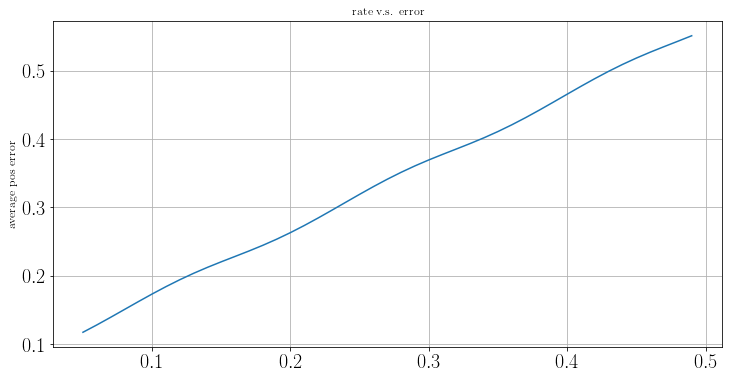

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import os
import sys
import time
import pickle
plt.rc('font', family='serif')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('figure', figsize=(12,6))
plt.rc('legend', fontsize=10)
plt.rc('axes', titlesize="larger")
plt.rc("axes", labelsize=20)
L = 0.3
rate = 0.04
output_log = np.zeros((45,2)) #[rate, avg error]
for i in range(45):
  rate += 0.01
  print(rate)
  state_log, f_log, error_log = simulate(x0, time_out)
  mag_pos_err = np.linalg.norm(np.array([error_log[:,0], error_log[:,1]]),axis=0)
  avg_pos_err = np.mean(mag_pos_err)
  output_log[i] = np.array([rate, avg_pos_err])
  

max_theta = np.max(np.abs(error_log[:, 2]))
avg_theta = np.mean(error_log[:, 2])
min_error = np.min(output_log[:, 1])
best_rate = output_log[output_log[:, 1].tolist().index(min_error)][0]

directory = ("drive/MyDrive/Simulations/Rate-Test-"+time.asctime(time.localtime())).replace(":", "-")
os.mkdir(directory)

with open("./"+directory+"/output_log.dat", "wb") as file:
    pickle.dump(output_log, file)

with open(directory+"/data.txt", "a") as f:
  f.write(
        "Minimum Average Error: %f\n" \
        "Best Rate: %f\n" \
        "Max Theta: %f\n" \
        "Average Theta: %fm\n"% (
        min_error, best_rate, max_theta, avg_theta
              ))
  

fig1 = plt.figure()
ax11 = fig1.add_subplot(111)
ax11.grid()
ax11.set_ylabel('average pos error')
ax11.set_title('rate v.s. error')
plt.plot(output_log[:,0], output_log[:, 1])
plt.savefig(directory+"/rate vs error.pdf")

[[0.5        0.55939137]
 [0.5        0.55939137]
 [0.5        0.55939137]
 [0.5        0.55939137]
 [0.5        0.55939137]
 [0.5        0.55939137]
 [0.5        0.55939137]
 [0.5        0.55939137]
 [0.5        0.55939137]
 [0.5        0.55939137]
 [0.5        0.55939137]
 [0.5        0.55939137]
 [0.5        0.55939137]
 [0.5        0.55939137]
 [0.5        0.55939137]
 [0.5        0.55939137]
 [0.5        0.55939137]
 [0.5        0.55939137]
 [0.5        0.55939137]
 [0.5        0.55939137]
 [0.5        0.55939137]
 [0.5        0.55939137]
 [0.5        0.55939137]
 [0.5        0.55939137]
 [0.5        0.55939137]
 [0.5        0.55939137]
 [0.5        0.55939137]
 [0.5        0.55939137]
 [0.5        0.55939137]
 [0.5        0.55939137]
 [0.5        0.55939137]
 [0.5        0.55939137]
 [0.5        0.55939137]
 [0.5        0.55939137]
 [0.5        0.55939137]
 [0.5        0.55939137]
 [0.5        0.55939137]
 [0.5        0.55939137]
 [0.5        0.55939137]
 [0.5        0.55939137]


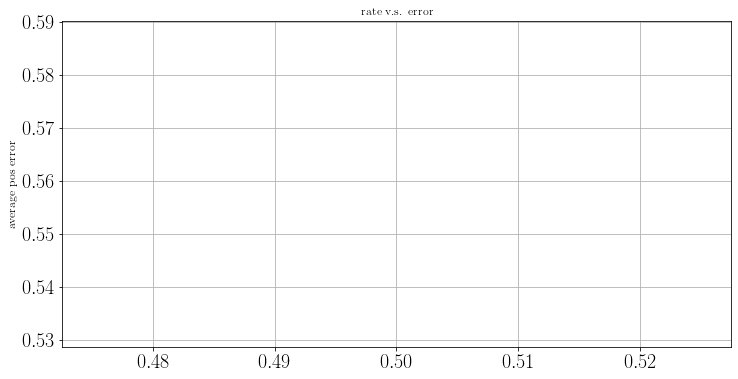

In [ ]:

directory = ("drive/MyDrive/Simulations/Rate-Test-"+time.asctime(time.localtime())).replace(":", "-")
os.mkdir(directory)

with open("./"+directory+"/output_log.dat", "wb") as file:
    pickle.dump(output_log, file)

with open(directory+"/data.txt", "a") as f:
  f.write(
        "Minimum Average Error: %f\n" \
        "Best Rate: %f\n" \
        "Max Theta: %f\n" \
        "Average Theta: %fm\n"% (
        min_error, best_rate, max_theta, avg_theta
              ))
  

fig1 = plt.figure()
ax11 = fig1.add_subplot(111)
ax11.grid()
ax11.set_ylabel('average pos error')
ax11.set_title('rate v.s. error')
plt.plot(output_log[:,0], output_log[:, 1])
plt.savefig(directory+"/rate vs error.pdf")

print(output_log)

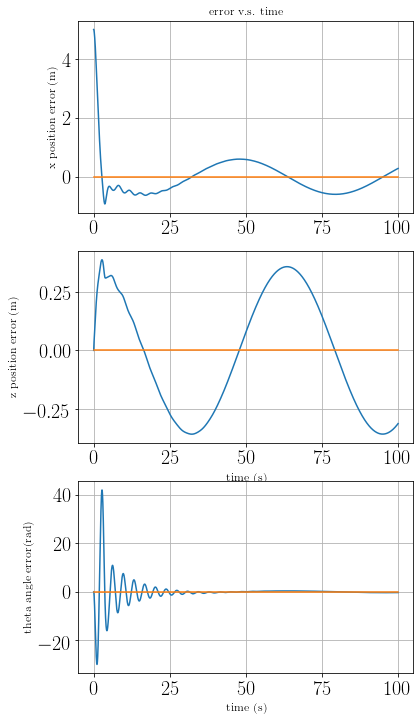

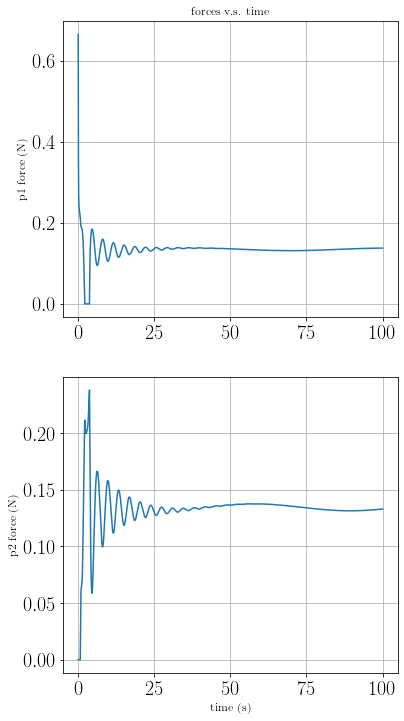

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import os
import sys
import time
import pickle
plt.rc('font', family='serif')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('figure', figsize=(6,12))
plt.rc('legend', fontsize=10)
plt.rc('axes', titlesize="larger")
plt.rc("axes", labelsize="larger")

log_error_x = des_state_log[:,0] - state_log[:,0]
log_error_y = des_state_log[:,1] - state_log[:,1]
error_log_theta = des_state_log[:,2] - state_log[:,2]

log_error_vel_x = des_state_log[:,3] - state_log[:,3]
log_error_vel_y = des_state_log[:,4] - state_log[:,4]
error_log_vel_theta = des_state_log[:,5] - state_log[:,5]

mag_pos_err = np.linalg.norm(np.array([log_error_x, log_error_y]),axis=0)
avg_pos_err = np.mean(mag_pos_err)
max_pos_err = np.max(mag_pos_err)
min_pos_err = np.min(mag_pos_err)

mag_vel_err = np.linalg.norm(np.array([log_error_vel_x, log_error_vel_y]),axis=0)
avg_vel_err = np.mean(mag_vel_err)
max_vel_err = np.max(mag_vel_err)
min_vel_err = np.min(mag_vel_err)

directory = ("drive/MyDrive/Simulations/Sim-"+time.asctime(time.localtime())).replace(":", "-")
os.mkdir(directory)

with open("./"+directory+"/log_dest_x.dat", "wb") as file:
    pickle.dump(des_state[0], file)
with open("./"+directory+"/log_dest_y.dat", "wb") as file:
    pickle.dump(des_state[1], file)

with open("./"+directory+"/log_err_x.dat", "wb") as file:
    pickle.dump(log_error_x, file)
with open("./"+directory+"/log_err_y.dat", "wb") as file:
    pickle.dump(log_error_y, file)

with open("./"+directory+"/log_err_vel_x.dat", "wb") as file:
    pickle.dump(log_error_vel_x, file)
with open("./"+directory+"/log_err_vel_y.dat", "wb") as file:
    pickle.dump(log_error_vel_y, file)

with open("./"+directory+"/t.dat", "wb") as file:
    pickle.dump(time_out, file)

with open(directory+"/data.txt", "a") as f:
  f.write(
        "Parameters:\n" \
        "Distance between CoM and CoL: %f\n" \
        
        "Average Position Error Magnitude: %fm\n" \
        "Maximum Position Error Magnitude: %fm\n" \
        "Minimum Position Error Magnitude: %fm\n" \
        "Average Velocity Error Magnitude: %fm/s\n" \
        "Maximum Velocity Error Magnitude: %fm/s\n" \
        "Minimum Velocity Error Magnitude: %fm/s\n"% (
        L, avg_pos_err,max_pos_err,min_pos_err,avg_vel_err,max_vel_err,min_vel_err
              ))



fig1 = plt.figure()
ax11 = fig1.add_subplot(311)
ax11.grid()
ax11.set_ylabel('x position error (m)')
ax11.set_title('error v.s. time')
x_position, = ax11.plot(np.linspace(0, time_out, int(time_out//dt)), log_error_x)
ax11.plot(np.array([0, time_out]), np.array([0,0]))

ax12 = fig1.add_subplot(312)
ax12.grid()
ax12.set_ylabel('z position error (m)')
ax12.set_xlabel('time (s)')
z_position, = ax12.plot(np.linspace(0, time_out, int(time_out//dt)), log_error_y)
ax12.plot(np.array([0, time_out]), np.array([0, 0]))

ax13 = fig1.add_subplot(313)
ax13.grid()
ax13.set_ylabel('theta angle error(rad)')
ax13.set_xlabel('time (s)')
theta_angle, = ax13.plot(np.linspace(0, time_out, int(time_out//dt)), error_log_theta*180.0/np.pi)
ax13.plot(np.array([0, time_out]), 180.0/np.pi*np.array([des_state[2], des_state[2]]))

fig2 = plt.figure()
ax21 = fig2.add_subplot(211)
ax21.grid()
ax21.set_ylabel('p1 force (N)')
ax21.set_title('forces v.s. time')
x_position, = ax21.plot(np.linspace(0, time_out, int(time_out//dt)), f_log[:, 0])

ax22 = fig2.add_subplot(212)
ax22.grid()
ax22.set_ylabel('p2 force (N)')
ax22.set_xlabel('time (s)')
z_position, = ax22.plot(np.linspace(0, time_out, int(time_out//dt)), f_log[:, 1])


# ax23 = fig2.add_subplot(413)
# ax23.grid()
# ax23.set_ylabel('p3 force (N)')
# ax23.set_xlabel('time (s)')
# theta_angle, = ax23.plot(np.linspace(0, time_out, int(time_out//dt)), f_log[:, 2])

# ax24 = fig2.add_subplot(414)
# ax24.grid()
# ax24.set_ylabel('p4 force (N)')
# ax24.set_xlabel('time (s)')
# theta_angle, = ax24.plot(np.linspace(0, time_out, int(time_out//dt)), f_log[:, 3])

In [ ]:
print(des_state_log[:,1])
print(state_log[:,1])

[0.00000000e+00 1.00000000e-06 2.00000000e-06 ... 1.99946675e-02
 1.99956673e-02 1.99966671e-02]
[0.         0.         0.         ... 0.04131527 0.04131728 0.04131929]


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


KeyboardInterrupt: ignored

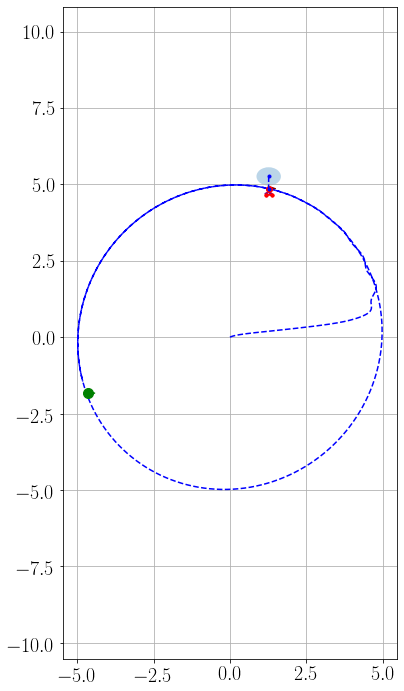

In [ ]:
!pip install JSAnimation
import matplotlib.pyplot as plt
from matplotlib import animation
from JSAnimation import IPython_display
from IPython.display import HTML

fig, ax = plt.subplots()
plt.axis('equal')
sampling = int(100) # Increasing this number decreases time to generate animation

def animate(t):
    ax.clear()
    # plt.xlim([0, 8])
    # plt.ylim([-1, 8])
    ax.grid()
    # Path
    plt.plot(state_log[:, 0], state_log[:, 1], 'b--')
    # target
    ax.plot(des_state[0], des_state[1], 'og', markersize=10)
    ax.arrow(des_state[0], des_state[1], 0.1*np.cos(des_state[2]), 0.1*np.sin(des_state[2]), width=0.03, color=[0,0.5,0])

    # current position and orientation
    xy = state_log[sampling*t, 0:2]
    ax.plot(xy[0], xy[1], 'ro')  # Center of mass
    ax.arrow(state_log[sampling*t, 0], state_log[sampling*t, 1], 0.1*np.cos(state_log[sampling*t,2]), 0.1*np.sin(state_log[sampling*t,2]), width=0.03, color=[0.5,0,0])
    # actuators
    # homogeneous vectors and rotations
    # homogenenous transformation
    theta = state_log[sampling*t, 2]

    T = np.eye(3)
    T[0:2, 0:2] = np.array([[np.cos(theta), -np.sin(theta)],
                            [np.sin(theta), np.cos(theta)]])
    T[0:2, 2] = state_log[sampling*t, 0:2]

    pos_p = np.zeros([2, n])
    rot_p = np.zeros([2, n])
    for i in range(n):
        pos_p[:, i] = T.dot(np.array([p[0, i], p[1, i], 1]))[0:2]
        rot_p[:, i] = T[0:2, 0:2].dot(R[:, 2*i:2*i+2].dot(f_log[sampling*t, i]*0.1*np.array([0, 1])))
        # print(rot_p)
    
    # position of the balloon
    pos_b = T.dot(np.array([0, L, 1]))[0:2]

    ax.plot(pos_p[0,:], pos_p[1, :], 'r.--')
    ax.plot([pos_b[0], xy[0]], [pos_b[1], xy[1]], 'b.--')
    balloon = Ellipse(pos_b, 0.8, 0.6, theta*180/np.pi)
    balloon.set_alpha(0.3)
    ax.add_artist(balloon)

    ax.plot([pos_p[0,-1], pos_p[0,0]], [pos_p[1, -1], pos_p[1, 0]], 'r.--')
    
    for i in range(n):
        ax.arrow(pos_p[0, i], pos_p[1, i], rot_p[0, i], rot_p[1, i], width=0.03, color=[0.5,0,0.5])
    
time = int(len(state_log)/sampling)
anim = animation.FuncAnimation(fig, animate, frames=time, interval=dt*1000*sampling)

HTML(anim.to_jshtml())